# IN3061/INM430 - Tiny DS Project Progress Report


***

 Student Name: Yousef Gharib

 Project Title: Analysis of Lego from years 1950-2017

***




## Datasets
I am using 2 Kaggle datasets for this project. 
* https://www.kaggle.com/rtatman/lego-database 
* https://www.kaggle.com/mterzolo/lego-sets

The lego database contains information on lego datasets from 1950 to 2017 in the form of 8 csv files which can be merged and a schema on how each csv file links to eachother, the lego sets contains 1 csv file which can be merged to a few of the csv files from the lego database. The only limitation is that lego-sets may not contain all the sets the lego-database contains.


In [58]:
# Importing Libraries
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
from sklearn import datasets, linear_model
import scipy.stats as sc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict 

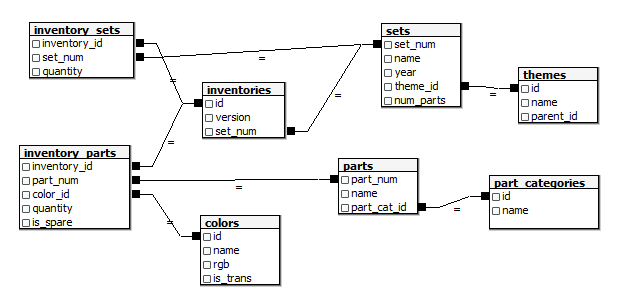

In [4]:
#Importing downloads_schema to help show which csv files can be merged together

Image(filename='downloads_schema.png')

In [7]:
#Importing all datasets

# Sets from Lego database
colors = pd.read_csv("colors.csv")
inv_parts = pd.read_csv("inventory_parts.csv")
inv = pd.read_csv("inventories.csv")
inv_sets = pd.read_csv("inventory_sets.csv")
parts = pd.read_csv("parts.csv")
part_cat = pd.read_csv("part_categories.csv")
sets = pd.read_csv("sets.csv")
themes = pd.read_csv("themes.csv")

# Second dataset
lego_sets = pd.read_csv("lego_sets.csv")

### Changing column names
Some datasets have different names for columns representing the same thing, for example color.csv and themes.csv have a coloumn called id

I created a function which renames columns so i can have unique columns and can merge datasets in the schema

In [8]:
def Change_column_name(df, old, new): # function changing column names
    df.rename(columns={old:new}, inplace=True)
 
# Changing color.csv columns
Change_column_name(colors, 'id', 'color_id')
Change_column_name(colors, 'name', 'color_name')

#Changing parts.csv columns
Change_column_name(parts, 'name', 'part_name')

#Changing part_cat.csv columns
Change_column_name(part_cat, 'id', 'part_cat_id')

#Changin themes.csv columns
Change_column_name(themes, 'id', 'theme_id')
Change_column_name(themes, 'name', 'theme_name')

#Changing sets.csv columns
Change_column_name(sets, 'name', 'set_name')

#Changing inventories.csv columns
Change_column_name(inv, 'id', 'inventory_id')

### Binning years

Binning years in sets.csv since not all years are included this makes comparisons easier. Information is lost when merging the Lego database and second dataset since the mutual column does not contain the exact same information for both datasets


In [9]:
#Creating a new column assigning year to decade
sets["binned_years"] = 0
for i in range(len(sets)):
    if sets["year"][i] < 1960 and sets["year"][i] >= 1950:
        sets["binned_years"][i] = "1950s"
    elif sets["year"][i] < 1970 and sets["year"][i] >= 1960:
        sets["binned_years"][i] = "1960s"
    elif sets["year"][i] < 1980 and sets["year"][i] >= 1970:
        sets["binned_years"][i] = "1970s"
    elif sets["year"][i] < 1990 and sets["year"][i] >= 1980:
        sets["binned_years"][i] = "1980s"
    elif sets["year"][i] < 2000 and sets["year"][i] >= 1990:
        sets["binned_years"][i] = "1990s"
    elif sets["year"][i] < 2010 and sets["year"][i] >= 2000:
        sets["binned_years"][i] = "2000s"
    elif sets["year"][i] < 2020 and sets["year"][i] >= 2010:
        sets["binned_years"][i] = "2010s"

C:\Users\youse\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\youse\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\youse\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

### Merging datasets

Merging datasets helps us connect and compare information. 

To compare how colours have changed we merge to form a dataset containing binned years as well as all the pieces used and their colour

In [12]:
c_ip = pd.merge(colors, inv_parts, on='color_id') #Merging colors.csv and inv_parts.csv on color_id
c_ip.head(3) # Dataset of lego pieces and colours

,color_id,color_name,rgb,is_trans,inventory_id,part_num,quantity,is_spare
0,-1,Unknown,0033B2,f,80,belvfair6,1,f
1,-1,Unknown,0033B2,f,80,belvfem26,1,f
2,-1,Unknown,0033B2,f,80,belvmale13,1,f


In [13]:
c_ip.tail(3) 

,color_id,color_name,rgb,is_trans,inventory_id,part_num,quantity,is_spare
580248,9999,[No Color],05131D,f,18322,75171stkpr01,1,f
580249,9999,[No Color],05131D,f,18704,34100,1,f
580250,9999,[No Color],05131D,f,18708,20243,1,f


"Unknown" and "[No Color]" may be considered outliers. After inpecting part_num with those 2 colours, they represent unique pieces such as stickers or minifigures and are not removed from the dataset.

In [15]:
s_t=pd.merge(sets,themes, on="theme_id") # Merging sets.csv and themes.csv on column theme_id
s_t.head(3) # Dataset of sets and themes

,set_num,set_name,year,theme_id,num_parts,binned_years,theme_name,parent_id
0,00-1,Weetabix Castle,1970,414,471,1970s,Castle,411.0
1,0011-2,Town Mini-Figures,1978,84,12,1970s,Supplemental,67.0
2,2181-1,Infomaniac,1997,84,4,1990s,Supplemental,67.0


In [17]:
s_t_inv = pd.merge(s_t,inv,on="set_num") # Merging s_t with inv.csv on set_num
s_t_inv.head(3) # Dataset of sets, themes and inventories

,set_num,set_name,year,theme_id,num_parts,binned_years,theme_name,parent_id,inventory_id,version
0,00-1,Weetabix Castle,1970,414,471,1970s,Castle,411.0,5574,1
1,0011-2,Town Mini-Figures,1978,84,12,1970s,Supplemental,67.0,5087,1
2,2181-1,Infomaniac,1997,84,4,1990s,Supplemental,67.0,14456,1


In [18]:
stc = pd.merge(s_t_inv,c_ip,on="inventory_id") # Merging s_t_inv and c_ip on Inventory_id
stc.head(3) # Dataset allowing us to compare colours used each decade.

,set_num,set_name,year,theme_id,num_parts,binned_years,theme_name,parent_id,inventory_id,version,color_id,color_name,rgb,is_trans,part_num,quantity,is_spare
0,00-1,Weetabix Castle,1970,414,471,1970s,Castle,411.0,5574,1,0,Black,05131D,f,3062a,8,f
1,00-1,Weetabix Castle,1970,414,471,1970s,Castle,411.0,5574,1,1,Blue,0055BF,f,3001a,4,f
2,00-1,Weetabix Castle,1970,414,471,1970s,Castle,411.0,5574,1,1,Blue,0055BF,f,3003,3,f


A lot of datasets had to be merged to allow colours to be compared. 

### Data derivation

Grouping by binned years and colour makes it much easier to create graphs comparing how colours have changed, and a new column is created telling us the percentage of each colour used per decade.

In [20]:
# Grouping stc by binned_years, color_name and rgb
color_year = stc.groupby(["binned_years","color_name","rgb"]).agg(color_count = ("color_name","count")).reset_index()

# Creating a new column in color_year called color_ratio which is the ratio of that color used for that decade
color_year["color_ratio"] = 0.0
for i in range(len(color_year)):
    color_year["color_ratio"][i] = (color_year["color_count"][i]/color_year[color_year["binned_years"] == color_year["binned_years"][i]]["color_count"].sum())*100

color_year.head(3)

C:\Users\youse\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,binned_years,color_name,rgb,color_count,color_ratio
0,1950s,Black,05131D,15,1.590668
1,1950s,Blue,0055BF,83,8.801697
2,1950s,Bright Green,4B9F4A,2,0.212089


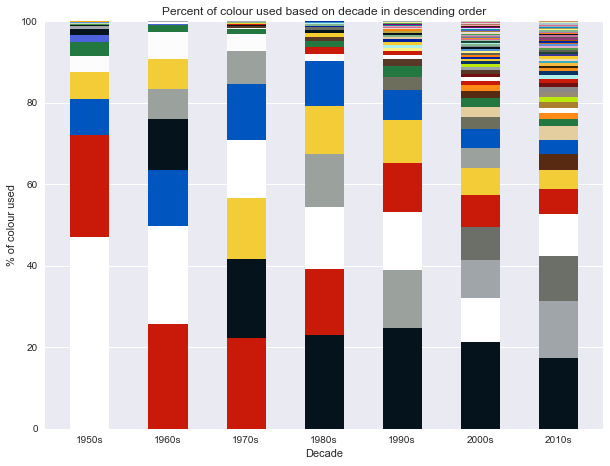

In [21]:
# Stacked barchart of colour used each decade in descending order
y = color_year["binned_years"].unique()
fig, ax = plt.subplots(figsize=(10, 7.5))    
for j in range(len(y)):
    k = color_year[color_year["binned_years"] == y[j]].sort_values("color_ratio",ascending=False).reset_index().drop("index",1)
    sumk = 0
    for i in range(len(k)):
        plt.bar(y[j], k["color_ratio"][i], 0.5, bottom = sumk, color = "#"+k["rgb"][i] )
        sumk += k["color_ratio"][i]
        
plt.xlabel("Decade")
plt.ylabel("% of colour used")
plt.title("Percent of colour used based on decade in descending order")

axes = plt.gca()
axes.set_ylim([0,100])
plt.savefig('colours.png')

The percentage of colours used graph was inspired from Carron, J. (2016). 67 Years of Lego Sets.

Next we create graphs to visualize how number of pieces, number of sets as well as unique number of themes have changed each decade

In [24]:
compare = s_t_inv.groupby(["binned_years"]).agg(avg_num_part = ("num_parts","mean"), unique_themes = ("theme_name","nunique"),sets_count=("theme_name","count")).reset_index()
compare.head(3) # Dataset allowing us to compare number of pieces, number of sets and unique number of themes

,binned_years,avg_num_part,unique_themes,sets_count
0,1950s,33.265152,6,132
1,1960s,68.155844,21,308
2,1970s,113.367021,40,564


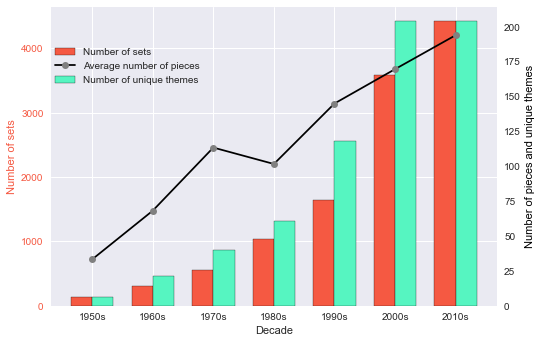

In [25]:
fig, ax1 = plt.subplots()

width = 0.35

color = '#F55942'
ax1.bar(compare.binned_years, compare.sets_count, -width,facecolor='#F55942', edgecolor="black",label='Number of sets',align='edge',zorder=1)
ax1.set_ylabel('Number of sets', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.plot(compare.binned_years, compare.avg_num_part,'black',marker='o',linestyle='-',markerfacecolor='grey',label='Average number of pieces',zorder=10)
ax2.bar(compare.binned_years, compare.unique_themes, width,facecolor='#56F5C1', edgecolor="black",label='Number of unique themes',align='edge')
ax2.set_ylabel('Number of pieces and unique themes', color='black')
ax2.grid(b=None)

ax1.set_xlabel("Decade")
fig.legend(bbox_to_anchor=(0.4,0.8))
fig.savefig('themes_parts.png')

We see number of sets, average pieces and unique themes all increase each decade. 

### Analysing price

The second dataset contains prices and is used to analyse how prices have changed.

For data cleaning, unwanted columns are removed, all numeric null values were replaced with the mean value of that column, null values in the categorical column review_difficulty are replaced with ‘Average’ and rows missing a theme name were dropped since there were only 3.

In [34]:
lego_sets = pd.read_csv("lego_sets.csv")
lego_sets = lego_sets.drop("prod_desc",1)
lego_sets = lego_sets.drop("prod_long_desc",1) #Removing unwanted columns
lego_sets = lego_sets.drop("set_name",1)

In [35]:
lego_sets.isnull().sum()

ages                    0
list_price              0
num_reviews          1620
piece_count             0
play_star_rating     1775
prod_id                 0
review_difficulty    2055
star_rating          1620
theme_name              3
val_star_rating      1795
country                 0
dtype: int64

In [36]:
# Dealing with null values 
lego_sets = lego_sets.fillna(lego_sets.mean()) # Filling numeric null values with mean of column

In [37]:
lego_sets.isnull().sum()

ages                    0
list_price              0
num_reviews             0
piece_count             0
play_star_rating        0
prod_id                 0
review_difficulty    2055
star_rating             0
theme_name              3
val_star_rating         0
country                 0
dtype: int64

In [38]:
# Dealing with null values 
lego_sets['review_difficulty'] = lego_sets['review_difficulty'].fillna('Average') # Replacing null values with Average

In [39]:
lego_sets.isnull().sum()

ages                 0
list_price           0
num_reviews          0
piece_count          0
play_star_rating     0
prod_id              0
review_difficulty    0
star_rating          0
theme_name           3
val_star_rating      0
country              0
dtype: int64

In [40]:
# Dealing with null values 
lego_sets = lego_sets.dropna() # Removing rows with no theme name

In [41]:
lego_sets.isnull().sum()

ages                 0
list_price           0
num_reviews          0
piece_count          0
play_star_rating     0
prod_id              0
review_difficulty    0
star_rating          0
theme_name           0
val_star_rating      0
country              0
dtype: int64

A separate dataset is created to anaylse prices in the United States since it had the most number of sets.

In [27]:
lego_us = lego_sets[lego_sets['country'] == "US"]
lego_us = lego_us.drop('country', 1)

Since sets.csv contains the binned years, merging lego_sets.csv and sets allows us to compare lego sets each decade.

The 2 datasets can be merged on product id in lego_sets.csv and set_num in sets.csv, however, the set_num values in sets.csv is slightly different to product id in lego_us, so a new column is made in sets.csv to match so they can be merged. 

In [44]:
sets["prod_id"] = 0
for i in range(len(sets)):
    sets["prod_id"][i] = sets["set_num"][i].split("-")[0]

sets.head(3)

C:\Users\youse\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\youse\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,set_num,set_name,year,theme_id,num_parts,binned_years,prod_id
0,00-1,Weetabix Castle,1970,414,471,1970s,0
1,0011-2,Town Mini-Figures,1978,84,12,1970s,11
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2,1980s,11


The product id in lego_sets.csv is converted to string so datasets can be merged

In [45]:
lego_sets["prod_id"] = lego_sets["prod_id"].astype("int64")
lego_sets["prod_id"] = lego_sets["prod_id"].astype("string")

In [47]:
l_set = pd.merge(lego_sets,sets,on="prod_id")
l_set = l_set.drop("set_num",1)
l_set = l_set.drop("theme_id",1)
l_set.head(3)

,ages,list_price,num_reviews,piece_count,play_star_rating,prod_id,review_difficulty,star_rating,theme_name,val_star_rating,country,set_name,year,num_parts,binned_years
0,6-12,29.9900,2.0,277.0,4.0,75823,Average,4.5,Angry Birds™,4.0,US,Bird Island Egg Heist,2016,282,2010s
1,6-12,31.1922,2.0,277.0,4.0,75823,Average,4.5,Angry Birds™,4.0,CA,Bird Island Egg Heist,2016,282,2010s
2,6-12,19.9900,2.0,168.0,4.0,75822,Easy,5.0,Angry Birds™,4.0,US,Piggy Plane Attack,2016,168,2010s


Next, a list of lego set IDs that are priced for the countries we want is made so we can compare prices for different countries fairly.

In [48]:
products = set(l_set[l_set["country"] == 'US'].prod_id.unique())
countries = ['CA', 'AU', 'AT', 'BE', 'CH', 'CZ', 'DE', 'DN', 'GB']
for country in countries:
    products = products & set(l_set[l_set["country"] == country].prod_id.unique())    

A dataset is made so we can compare means and standard deviations of prices for different countries each decade

In [49]:
countrys = ['GB','CA', 'AU', 'AT', 'BE', 'CH', 'CZ', 'DE', 'DN']
price_var = l_set[(l_set['country'] == 'US')|(l_set['country'] == 'GB')|(l_set['country'] == 'CA')|(l_set['country'] == 'AU')|(l_set['country'] == 'AT')|(l_set['country'] == 'BE')|(l_set['country'] == 'CH')|(l_set['country'] == 'CZ')|(l_set['country'] == 'DN')|(l_set['country'] == 'DE')]
p_Var = price_var[price_var["prod_id"].isin(products)]
p_Var.groupby(["binned_years","country"]).agg(avg = ("list_price","mean"),var = ("list_price","std"))

avg         var
binned_years country                        
1990s        AT        10.662800   10.783378
             AU         7.972400    8.061017
             BE        10.662800   10.783378
             CA         8.962200    9.376236
             CH        10.608000   10.818734
             CZ        10.032000    9.503515
             DE        10.052800    9.920708
             DN         9.000000    9.333810
             GB         8.736000    8.414571
             US         8.740000    8.838835
2000s        AT        23.472800   15.540042
             AU        21.082400   11.548916
             BE        24.387800   17.253405
             CA        19.492200    7.800000
             CH        23.358000   15.867476
             CZ        23.952000   16.970563
             DE        24.387800   13.802724
             DN        20.400000   11.341958
             GB        25.186000   16.276568
             US        18.990000    7.348469
2010s        AT        93.423887  123.480288
             AU        90.224698  112.606510
             BE        99.417800  127.298721
             CA        75.264429   97.312485
             CH        93.959042  128.321852
             CZ       103.551801  131.889190
             DE        98.197800  126.721756
             DN        78.944348   95.753395
             GB        93.796348  117.528925
             US        81.632857  115.823673

Using the list of Lego sets available for all countries, we create a dataset with those lego sets for countries we are interested in and we plot line graphs for each country representing the average price each decade.

In [50]:
fair= l_set[l_set["prod_id"].isin(products)]

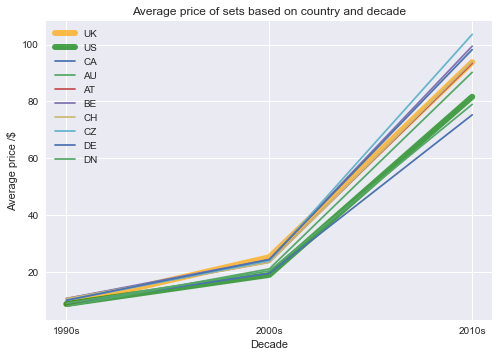

In [51]:
countries = ['CA', 'AU', 'AT', 'BE', 'CH', 'CZ', 'DE', 'DN']

fig, ax1 = plt.subplots()

GB = fair[fair["country"] == 'GB'].groupby("binned_years").agg(avg_price=("list_price","mean")).reset_index()
US = fair[fair["country"] == 'US'].groupby("binned_years").agg(avg_price=("list_price","mean")).reset_index()

ax1.plot(GB.binned_years, GB.avg_price, marker='', color='orange', linewidth=6, alpha=0.7, label = 'UK')
ax1.plot(US.binned_years, US.avg_price, marker='', color='green', linewidth=6, alpha=0.7, label = 'US')

for country in countries:
    c = fair[fair["country"] == country].groupby("binned_years").agg(avg_price=("list_price","mean")).reset_index()
    ax1.plot(c.binned_years,c.avg_price,label=country)
    
plt.legend()
plt.title('Average price of sets based on country and decade')
plt.xlabel("Decade")
plt.ylabel("Average price /$")
plt.savefig("price_country_decade.png")

Finally, we use the lego_us dataset to compare prices of lego sets as well as build linear regression models.

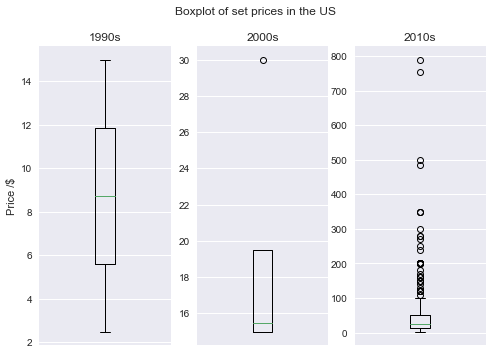

In [52]:
fig, axs = plt.subplots(1, 3)
usbox = [l_set[(l_set["binned_years"] == '1990s') & (l_set["country"] == 'US')]['list_price'], l_set[(l_set["binned_years"] == '2000s') & (l_set["country"] == 'US')]['list_price'], l_set[(l_set["binned_years"] == '2010s') & (l_set["country"] == 'US')]['list_price']]

# basic plot
axs[0].boxplot(usbox[0])
axs[0].set_title("1990s")
axs[0].set_ylabel("Price /$")
axs[0].set_xticks([])
# notched plot
axs[1].boxplot(usbox[1])
axs[1].set_title("2000s")
axs[1].set_xticks([])
# change outlier point symbols
axs[2].boxplot(usbox[2])
axs[2].set_title("2010s")
axs[2].set_xticks([])

fig.suptitle("Boxplot of set prices in the US")

plt.savefig("price_boxplot.png")

Plotting a boxplot of lego sets each decade shows outliers which are a lot more frequent in the 2010s.

We create a new dataset using One hot encoding on categorical columns to have more variables for linear regression.

In [54]:
lego_us_enc = pd.get_dummies(data=lego_us, columns=["ages","theme_name","review_difficulty"],prefix='',prefix_sep='')
lego_us_enc

,list_price,num_reviews,piece_count,play_star_rating,prod_id,star_rating,val_star_rating,10+,10-14,10-16,...,Stygimoloch Breakout,T. rex Transport,THE LEGO® BATMAN MOVIE,THE LEGO® NINJAGO® MOVIE™,Technic,Average,Challenging,Easy,Very Challenging,Very Easy
0,29.99,2.0,277.0,4.0,75823.0,4.5,4.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,19.99,2.0,168.0,4.0,75822.0,5.0,4.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,12.99,11.0,74.0,4.3,75821.0,4.3,4.1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,99.99,23.0,1032.0,3.6,21030.0,4.6,4.3,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,79.99,14.0,744.0,3.2,21035.0,4.6,4.1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,9.99,1.0,48.0,5.0,70628.0,5.0,5.0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
813,9.99,11.0,109.0,4.5,70606.0,4.7,4.8,0,0,0,...,0,0,0,1,0,0,0,1,0,0
814,9.99,7.0,102.0,4.0,41487.0,5.0,4.7,1,0,0,...,0,0,0,0,0,0,0,1,0,0
815,9.99,5.0,89.0,3.2,41488.0,4.4,4.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Correlation of variables with list price tells us which variables most affect the price of a Lego set

In [55]:
lego_us_enc.corr()[['list_price']].sort_values(by="list_price",ascending = False).head(12)

,list_price
list_price,1.000000
piece_count,0.863959
Challenging,0.492232
SERIOUS PLAY®,0.458823
16+,0.454084
prod_id,0.439090
num_reviews,0.424305
6+,0.300810
14+,0.300395
Creator Expert,0.256458


Next we start building our simple linear regression model. We use a train test split initially to get the hyperparameters and plot a graph to compare with actual prices. For simple linear regression, we use 1 predictor, piece count, and we want to predict list price.

In [62]:
#Setting Variables for simple linear regression
X_us = lego_us_enc.iloc[:,1:]
Y_us = lego_us_enc[["list_price"]]

In [63]:
# Train test split
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_us[["piece_count"]], Y_us, test_size=0.25)

regl = LinearRegression().fit(Xl_train , yl_train)
regl.coef_, regl.intercept_

(array([[0.08822166]]), array([10.12793822]))

In [68]:
line = regl.predict(X_us[["piece_count"]])

Created an array of Y coordinates which make the line of best fit.

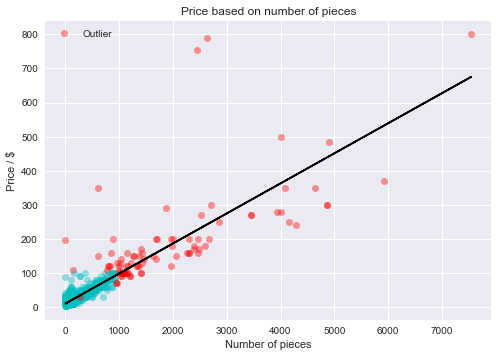

In [69]:
X_us = lego_us_enc.iloc[:,1:]
Y_us = lego_us_enc.iloc[:,0]
price = Y_us
piece_count = X_us.piece_count
p_IQR = price.describe()['75%'] - price.describe()['25%']
a_IQR = piece_count.describe()['75%'] - piece_count.describe()['25%']
p_min, p_max = price.describe()['25%'] - 1.5*p_IQR, price.describe()['75%'] + 1.5*p_IQR
a_min, a_max = piece_count.describe()['25%'] - 1.5*a_IQR, piece_count.describe()['75%'] + 1.5*a_IQR
for i in range(len(X_us)):
    if price[i] < p_min or price[i] > p_max or piece_count[i] < a_min or piece_count[i] > a_max:
        plt.plot(piece_count[i], price[i],'ro',alpha = 0.4)
    else:
        plt.plot(piece_count[i], price[i],'co',alpha=0.4)

plt.plot(piece_count[0], price[0],'ro',alpha = 0.4,label='Outlier')
plt.plot(piece_count, line, 'black')        
plt.xlabel("Number of pieces")
plt.ylabel("Price / $")
plt.title("Price based on number of pieces")
plt.legend()
plt.savefig("s_l_r.png")

Next i used 10 fold cross validation on simple linear regression, and calculated the mean squared error as well as average R squared value

In [71]:
reg = LinearRegression()
scoresl = cross_val_score(regl, X_us[["piece_count"]], Y_us, cv = 10)
predictionsl = cross_val_predict(reg, X_us[["piece_count"]], Y_us, cv=10)
mean_squared_error(Y_us,predictionsl),scoresl.mean()

(1479.288908075482, 0.7494819234565984)

Repeated 10 fold cross validation on multiple linear regression with predictors being the top 10 highly correlated variables with list price excluding product id

In [72]:
# Multiple linear regression using top 10 highest correlated variables 
top_10 = ['piece_count','Challenging','SERIOUS PLAY®','16+','num_reviews', '6+','14+','Creator Expert', '11-16','9-14']
X_us_top = lego_us_enc[top_10]

In [73]:
scores = cross_val_score(reg, X_us_top, Y_us, cv = 10)
predictions = cross_val_predict(reg, X_us_top, Y_us, cv=10)
mean_squared_error(Y_us, predictions),scores.mean()

(1437.7342922371085, 0.7526720988671037)

Comparing mean squared error and average R squared value of simple linear regression and multiple linear regression, we see that multiple linear regression has a lower mean squared error and higher R squared values suggesting its a better model to use to predict the price of a Lego set.